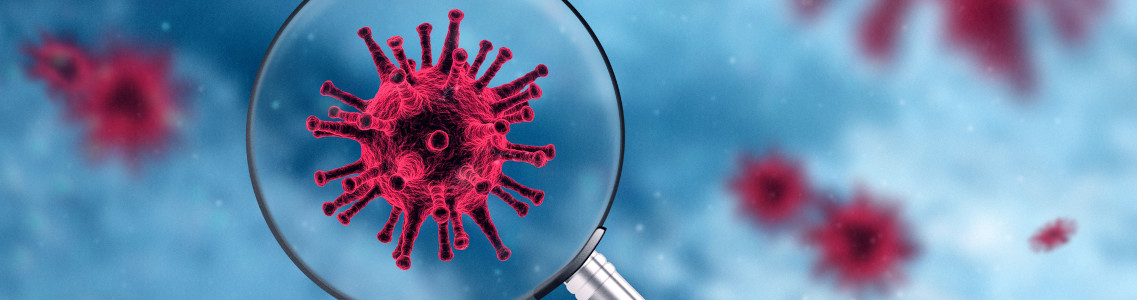

## Implementacja dyskretnego modelu kontroli epidemii poprzez śledzenie kontaktów (na podstawie artykułu [Hellewell et al.](https://www.sciencedirect.com/science/article/pii/S2214109X20300747))

- COVID-19, wykryty pod koniec 2019 roku w Wuhan, Chiny, szybko rozprzestrzenił się na całym świecie, powodując globalne zagrożenie zdrowotne
- Celem projektu było ocenić skuteczność izolacji przypadków oraz śledzenia kontaktów w kontroli transmisji COVID-19

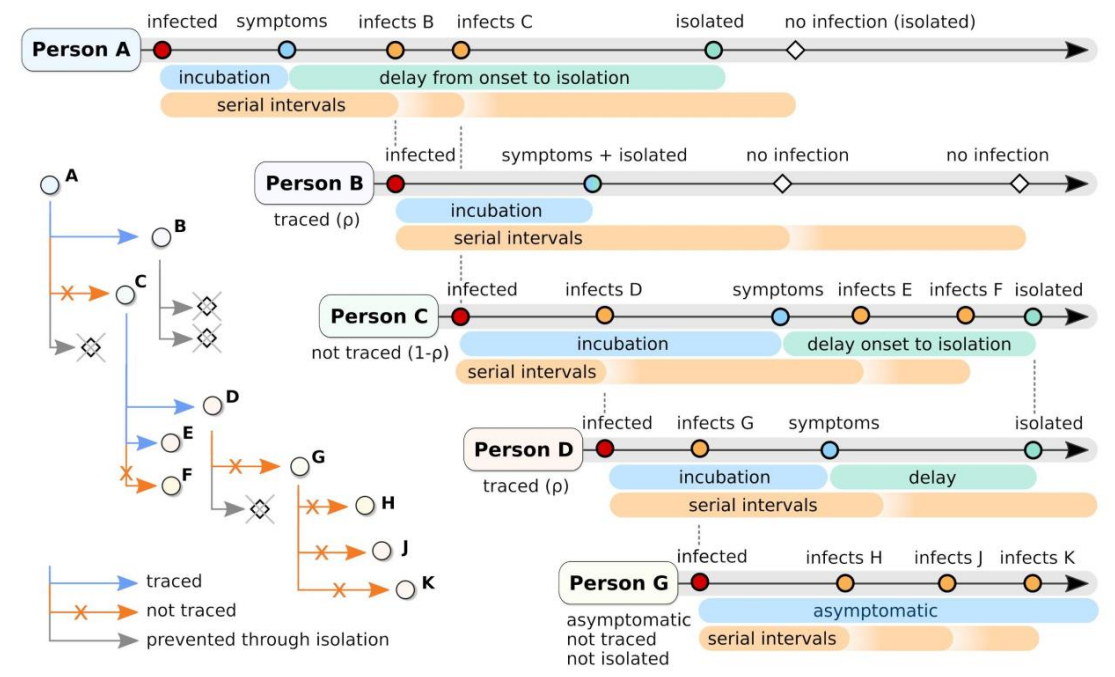

> Symulacja zaczyna się od N_0 początkowych przypadków zakażeń (5, 20, albo 40)

> Przyjęto, że izolacja jest na 100% skuteczna w zapobieganiu dalszej transmisji

> Każdy przypadek charakteryzuje się następnymi parametrami: liczbą produkowanych zakażeń (~NBinom), okresem inkubacji (~Weibull) i opóźnieniem od początku do izolacji (~Weibull)

> Każdy nowy przypadek z prawdopodobieństwem p został zidentyfikowany poprzez śledzenie. Śledzonę zakażone zostali izolowanę odrazy po objawach

> Ponadto każdy przypadek miał niezależne prawdopodobieństwo bycia podklinicznym i dlatego nie został wykryty ani przez samozgłoszenie, ani przez śledzenie kontaktów. Nowe wtórne przypadki spowodowane przez przypadek podkliniczny zostały pominięte przez śledzenie kontaktów i mogły zostać wyizolowane tylko na podstawie objawów.

> Parametry rozkładów były obliczane numerycznie na podstawie danych z tabeli

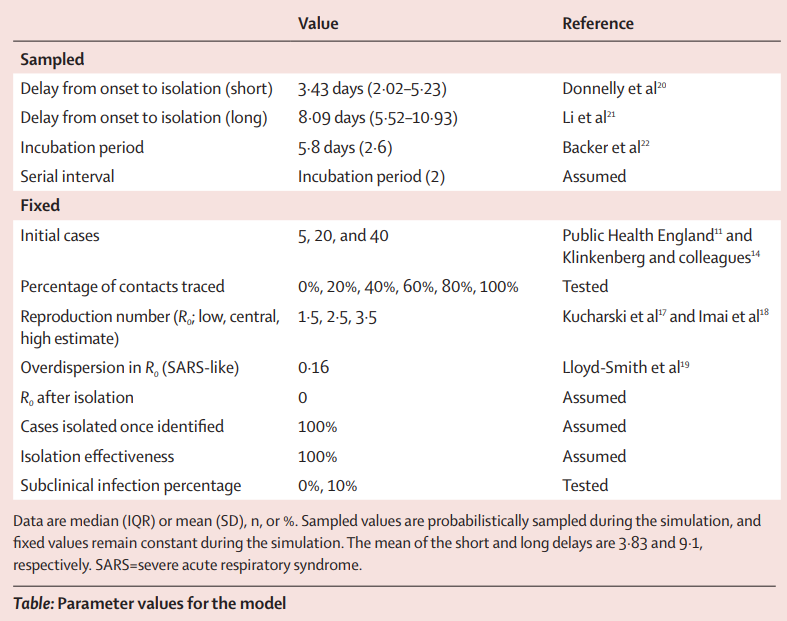

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from simulation_backend import Scenario, ScenarioParameters

import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.stats import weibull_min

plt.style.use('ggplot')

### Long and short delay

In [33]:
def estimate_weibull_params(mean, median, q1, q3):
    def objective(params):
        k, lam = params
        
        theoretical_mean = lam * gamma(1 + 1 / k)
        theoretical_median = lam * (np.log(2)) ** (1 / k)
        theoretical_q1 = lam * (np.log(4 / 3)) ** (1 / k)
        theoretical_q3 = lam * (np.log(4)) ** (1 / k)
        
        mean_error = ((theoretical_mean - mean) / mean) ** 2
        median_error = ((theoretical_median - median) / median) ** 2
        q1_error = ((theoretical_q1 - q1) / q1) ** 2
        q3_error = ((theoretical_q3 - q3) / q3) ** 2
        
        return mean_error + median_error + q1_error + q3_error
    
    initial_guess = [2.0, mean]
    bounds = [(0.1, 10), (0.1, 20)]
    
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
    
    return result.x

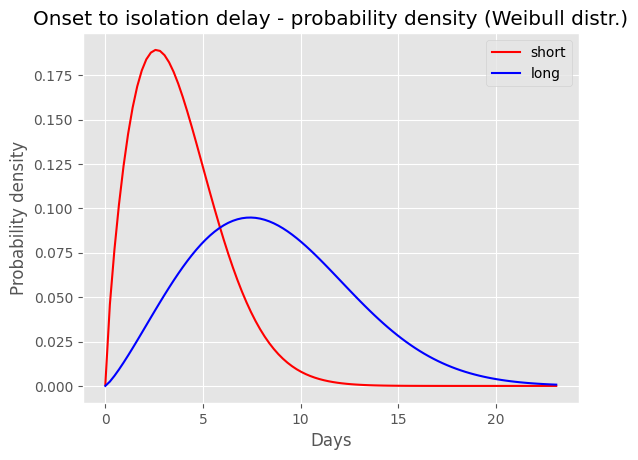

In [49]:
fig, ax = plt.subplots(1, 1)

weibull_c_short, weibull_lambda_short = estimate_weibull_params(mean=3.43, median=3.83, q1=2.02, q3=5.23)

weibull_c_long, weibull_lambda_long = estimate_weibull_params(mean=9.1, median=8.09, q1=5.52, q3=10.93)

x = np.linspace(weibull_min.pdf(0.01, weibull_c_short, scale=weibull_lambda_long),
                weibull_min.ppf(0.99, weibull_c_short, scale=weibull_lambda_long), 100)
ax.plot(x, weibull_min.pdf(x, weibull_c_short, scale=weibull_lambda_short),'r-', label="short")
ax.plot(x, weibull_min.pdf(x, weibull_c_long, scale=weibull_lambda_long),'b-', label="long")
plt.ylabel("Probability density")
plt.xlabel("Days")
plt.legend()
_ = plt.title("Onset to isolation delay - probability density (Weibull distr.)")

### Incubation period

In [37]:
def estimate_weibull_from_mean_std(mean, std):
    def objective(params):
        k, lam = params

        theoretical_mean = lam * gamma(1 + 1 / k)        
        theoretical_var = lam ** 2 * (gamma(1 + 2 / k) - (gamma(1 + 1 / k)) ** 2)

        observed_var = std**2
        
        mean_error = (theoretical_mean - mean) ** 2
        var_error = (theoretical_var - observed_var) ** 2
        
        return mean_error + var_error
    
    result = minimize(objective, x0=[2.0, mean], bounds=[(0.1, 10), (0.1, 20)], method='L-BFGS-B')
    k = result.x[0]
    
    lambda_param = mean / gamma(1 + 1 / k)
    
    return k, lambda_param

mean, variance:


(np.float64(5.8), np.float64(6.759995907417632))

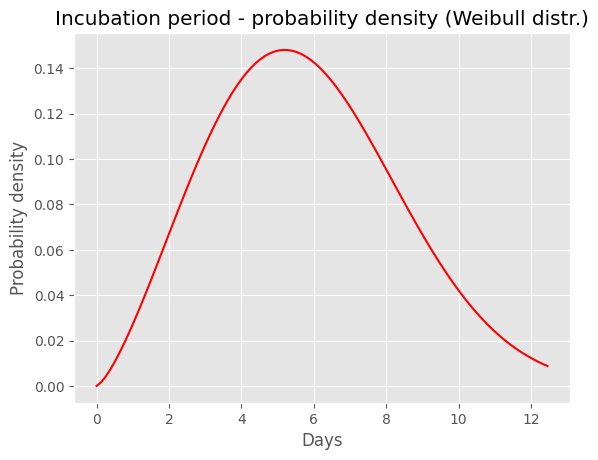

In [50]:
from scipy.stats import weibull_min

fig, ax = plt.subplots(1, 1)
weibull_c , weibull_lambda = estimate_weibull_from_mean_std(5.8, 2.6)
x = np.linspace(weibull_min.pdf(0.01, weibull_c, scale=weibull_lambda),
                weibull_min.ppf(0.99, weibull_c, scale=weibull_lambda), 100)
ax.plot(x, weibull_min.pdf(x, weibull_c, scale=weibull_lambda),'r-')
plt.ylabel("Probability density")
plt.xlabel("Days")
_ = plt.title("Incubation period - probability density (Weibull distr.)")
print("mean, variance:")
weibull_min.stats(weibull_c, scale=weibull_lambda)

## Symulacji

Kontrola epidemii została zdefiniowana jako brak nowych zakażeń między 12 a 16 tygodniem od wystąpienia pierwszych przypadków. 

Przyjęto, że wybuchy epidemii, które osiągnęły łącznie 5000 przypadków, były zbyt duże, aby można je było kontrolować w ciągu 12-16 tygodni i zostały sklasyfikowane jako ogniska niekontrolowane

In [48]:
num_simulations = 1000
T = 7*16
T_control = 7*12

R_0_base = 2.5
initial_cases_base = 20
onset_to_isolation_base = 'short'
transmission_before_symptoms_percentage_base = 15
subclinical_prob_base = 0

In [3]:
rhos = np.linspace(0, 1, num=6)
list(rhos)

[np.float64(0.0),
 np.float64(0.2),
 np.float64(0.4),
 np.float64(0.6000000000000001),
 np.float64(0.8),
 np.float64(1.0)]

#### Odsetek kontrolowanych epidemij dla scenariusza bazowego oraz różnej liczby przypadków początkowych

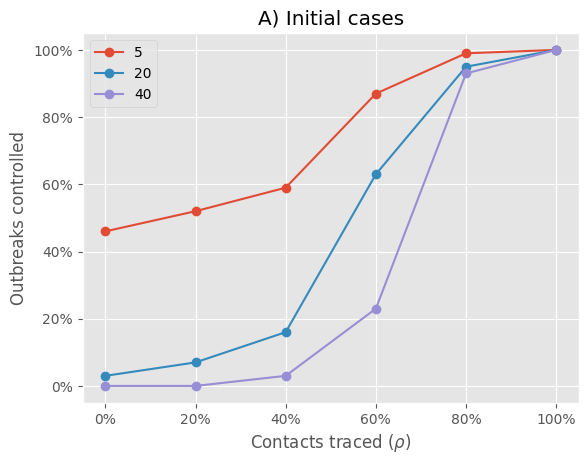

In [4]:
fig, ax = plt.subplots(1)

for initial_cases in [5, 20, 40]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(
            T = T, 
            T_control = T_control,
            initial_cases = initial_cases,
            rho = rho,
            R_0 = R_0_base,
            onset_to_isolation = onset_to_isolation_base,
            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage_base,
            subclinical_prob = subclinical_prob_base
        )
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=initial_cases)
        
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("A) Initial cases")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

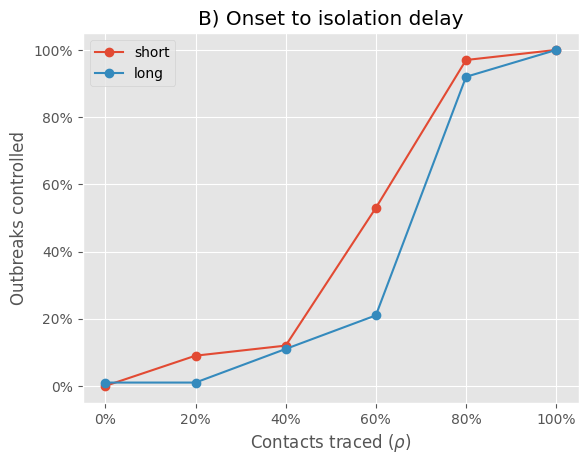

In [5]:
fig, ax = plt.subplots(1)

for onset_to_isolation in ["short", "long"]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(
            T = T, 
            T_control = T_control,
            initial_cases = initial_cases_base,
            rho = rho,
            R_0 = R_0_base,
            onset_to_isolation = onset_to_isolation,
            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage_base,
            subclinical_prob = subclinical_prob_base
        )
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=onset_to_isolation)

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("B) Onset to isolation delay")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

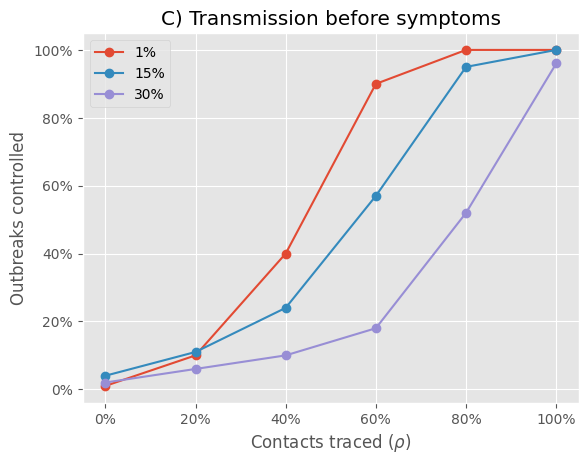

In [6]:
fig, ax = plt.subplots(1)

for transmission_before_symptoms_percentage in [1, 15, 30]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(
            T = T, 
            T_control = T_control,
            initial_cases = initial_cases_base,
            rho = rho,
            R_0 = R_0_base,
            onset_to_isolation = onset_to_isolation_base,
            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage,
            subclinical_prob = subclinical_prob_base
        )
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(transmission_before_symptoms_percentage)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("C) Transmission before symptoms")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

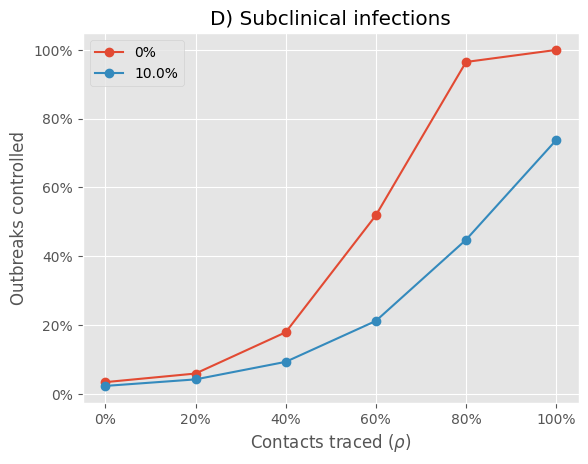

In [6]:
fig, ax = plt.subplots(1)

for subclinical_prob in [0, 0.1]:
    average_controlled_outbreaks = []
    for rho in rhos:
        params = ScenarioParameters(
            T = T, 
            T_control = T_control,
            initial_cases = initial_cases_base,
            rho = rho,
            R_0 = R_0_base,
            onset_to_isolation = onset_to_isolation_base,
            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage_base,
            subclinical_prob = subclinical_prob
        )
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)    
    plt.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=str(subclinical_prob*100)+"%")

plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("D) Subclinical infections")
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()

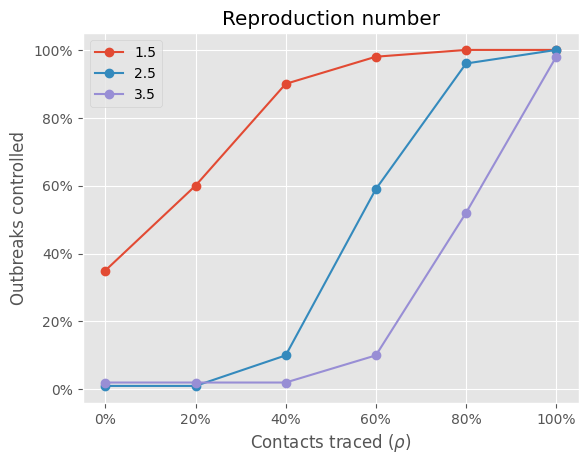

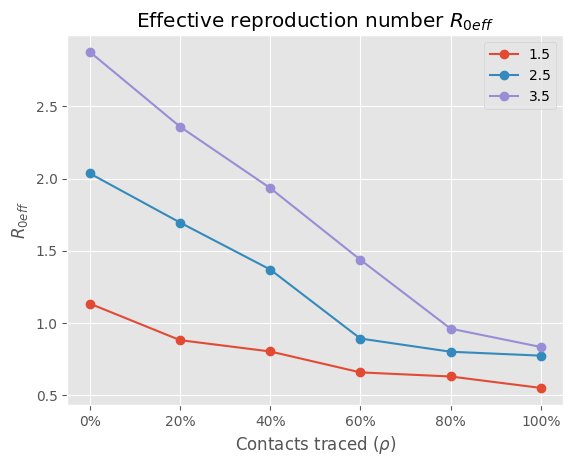

In [8]:
fig1, ax1 = plt.subplots(1)
fig2, ax2 = plt.subplots(1)

for R_0 in [1.5, 2.5, 3.5]:
    average_controlled_outbreaks = []
    effective_R_0 = []
    for rho in rhos:
        params = ScenarioParameters(
            T = T, 
            T_control = T_control,
            initial_cases = initial_cases_base,
            rho = rho,
            R_0 = R_0,
            onset_to_isolation = onset_to_isolation_base,
            transmission_before_symptoms_percentage = transmission_before_symptoms_percentage_base,
            subclinical_prob = subclinical_prob_base
        )
        scen = Scenario(params)
        stats = scen.run_simulations(num_simulations = num_simulations)
        average_controlled_outbreaks.append(stats.controlled_percentage)
        effective_R_0.append(stats.effective_R_0_median)
    ax1.plot(rhos, average_controlled_outbreaks, '-', marker = 'o', label=R_0)
    ax2.plot(rhos, effective_R_0, '-', marker = 'o', label=R_0)

plt.sca(ax1)
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"Outbreaks controlled")
plt.title("Reproduction number")
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.sca(ax2)
plt.xlabel(r"Contacts traced ($\rho$)")
plt.ylabel(r"$R_{0eff}$")
plt.title("Effective reproduction number $R_{0eff}$")
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()